## ID Mapping

This notebook explores the relationship between 'customers', schools sites, account_uuids and meter_uuids in the prop 39 data. 

In general, an account_uuid generally corresponds with an individual school, although there are some exceptions (which generally look to be typos and other data quality issues). 

'Customers' may be school districts or other entities, but may also be schools themselves. 

There is a strictly heirarchical tree relationship between the following three columns:

```
customer_name > account_uuid > meter_uuid
```

Other notes from looking at the PEPS_Data.xlsx definitions table:

* LEA (Local Educational Agency) may point to a school but may also point to a district, probably not useful for matching to a meter
* "Site CDS Code" = "The unique identifying code based on the CDS code for the school or district facility." If this is available in the xml files, we should grab it from there

### Notebook Config

In [1]:
db_pass = ""
with open('data_db.cfg','r') as f:
    for line in f:
        s = line.split("=")
        if s[0].strip() == "user":
            db_user = s[1].strip()
        if s[0].strip() == "pass":
            db_pass = ":" + s[1].strip()
        if s[0].strip() == "db":
            db_db = s[1].strip()

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import mysql.connector, os, datetime
from sqlalchemy import create_engine

In [3]:
engine = create_engine('mysql+mysqlconnector://' + db_user + db_pass + '@localhost/' + db_db, echo=False)
conn = engine.connect()

### Account table

In [4]:
account_df = pd.read_sql('SELECT * FROM account;', con=engine)
print len(account_df)
account_df.head(3)

2185


,id,account_uuid,meter_uuid,zip5,customer_account,customer_city,customer_name,customer_zip,lea_customer,rate_schedule_id,school_city,school_site_name,school_site_zip,utility_name
0,1,1100176106751,8496493494,94544,None,HAYWARD,ALAMEDA COUNTY OFFICE OF EDUCATION,94544-1136,None,E19S,Hayward,Alameda County Special Education,94544-1136,PacificGasElectric
1,2,1612340000000,5637199749,94560,None,NEWARK,NEWARK UNIFIED SCHOOL DISTRICT,94560-2554,None,HA10S,Newark,LEA,94560-0385,PacificGasElectric
2,3,1612340130054,5637199200,94560,None,NEWARK,NEWARK UNIFIED SCHOOL DISTRICT,94560-2554,None,A10S,Newark,Newark Memorial High,94560-5007,PacificGasElectric


### General lay of the land

In [5]:
df = pd.read_sql('SELECT * FROM account LIMIT 1;', con=engine)
for c in df.columns:
    df[c] = pd.read_sql('SELECT COUNT(DISTINCT(' + c + ')) FROM account;', con=engine)
df

,id,account_uuid,meter_uuid,zip5,customer_account,customer_city,customer_name,customer_zip,lea_customer,rate_schedule_id,school_city,school_site_name,school_site_zip,utility_name
0,2185,1078,2185,302,0,149,192,188,0,26,203,960,1018,1


In [6]:
query = '''
SELECT COUNT(count) 
FROM (
  SELECT COUNT(*) AS count
  FROM account
  GROUP BY school_city, school_site_name
) AS t1;
'''
pd.read_sql(query, con=engine)

,COUNT(count)
0,1068


Based on the above, we summarize:

* there are 2185 rows in the accounts table
* there are 2185 distinct meter_uuid values
* there are 1078 distinct account_uuid values
* there are 1068 distinct school_city + school_site_name pairs
* there are 1018 distinct school_site_zips (9-digit zips)
* there are 192 distinct customer_names


### How does account_uuid relate to distinct school_city + school_name pairs?

In [7]:
account_df['site_pair'] = account_df['school_city'] + "_" + account_df['school_site_name']

In [8]:
comp = account_df[['site_pair','account_uuid']]
print len(comp)
comp = comp.drop_duplicates()
print len(comp)
comp.head(3)

2185
1083


,site_pair,account_uuid
0,Hayward_Alameda County Special Education,1100176106751
1,Newark_LEA,1612340000000
2,Newark_Newark Memorial High,1612340130054


Note that 1083 is greater than 1078, which is the number of distinct account_uuids: there are thus some account_uuids with multiple site_pair associations. As shown below, these cases look to be caused by discrepencies in site naming texts.

In [9]:
account_uuid_doubles = comp[comp.duplicated(subset='account_uuid', keep=False)].sort_values(by='account_uuid')
account_uuid_doubles

,site_pair,account_uuid
684,FRESNO_Sequoia Middle,10621666057335
1816,Fresno_Sequoia Middle,10621666057335
849,Bakersfield_North High School,15635291534775
1858,Bakersfield_North High,15635291534775
1241,Arroyo Grande_Arroyo Grande High,40687594030557
1969,ARROYO GRANDE_ARROYO GRANDE HIGH,40687594030557
1312,REDWOOD CITY_LEA,41690620000000
2039,SAN CARLOS_LEA,41690620000000
1349,SUNNYVALE_CUPERTINO MIDDLE,43694196046767
2048,Sunnyvale_Cupertino Middle,43694196046767


There are more cases of duplicated site_pair values. These look to be caused by either typos in the account_uuid values, or by the use of "LEA" in the site_name category.

In [10]:
site_pair_doubles = comp[comp.duplicated(subset='site_pair', keep=False)].sort_values(by='site_pair')
site_pair_doubles

,site_pair,account_uuid
839,Bakersfield_Bakersfield Adult School,15635291530708
1853,Bakersfield_Bakersfield Adult School,15635291530609
950,PETALUMA_LEA,21653420000000
1876,PETALUMA_LEA,21653750000000
1125,Quincy_LEA,32669690000000
1913,Quincy_LEA,32103220000000
1615,Red Bluff_LEA,52716390000000
2160,Red Bluff_LEA,52716210000000
1032,SALINAS_LEA,27661420000000
1078,SALINAS_LEA,27738250000000


### Hierarchical tree relationship

Testing this hypothesis:

* The following three fields display a hierarchical tree relationship: customer_name > account_uuid > meter_uuid

Note that this would mean that (a) each distinct meter_uuid must be associated with just one account_uuid and that (b) each distinct account_uuid must be associated with just one customer_name.

Also note that (a) is true since there is only one instance of each meter_uuid in the table, so we just need to test (b).

In [11]:
customer_name_account_df = account_df[['customer_name','account_uuid']]
customer_name_account_df = customer_name_account_df.drop_duplicates()
print len(customer_name_account_df)
customer_name_account_df.head(3)

1078


,customer_name,account_uuid
0,ALAMEDA COUNTY OFFICE OF EDUCATION,1100176106751
1,NEWARK UNIFIED SCHOOL DISTRICT,1612340000000
2,NEWARK UNIFIED SCHOOL DISTRICT,1612340130054


Note from the 'lay of the land' section above that there are 1078 distinct account_uuids in the table, so they are all unique and thus must each be associated with just one customer_name.

So the hierarchical relationship holds.

There are various ways of visualizing the overall mapping - e.g. as a tree or [sunburst](https://bl.ocks.org/mbostock/4348373), below we just consider the distributions of accounts per customer and meters per account.

In [12]:
customer_name_groups = customer_name_account_df.groupby('customer_name').count()
customer_name_groups.head()

,account_uuid
customer_name,
ACALANES UNION HIGH SCHOOL DISTRICT,5
ALAMEDA COUNTY OFFICE OF EDUCATION,1
ALLENSWORTH ELEMENTARY SCHOOL,1
ALTERNATIVES IN ACTION,1
ALVINA SCHOOL,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107e84710>]], dtype=object)

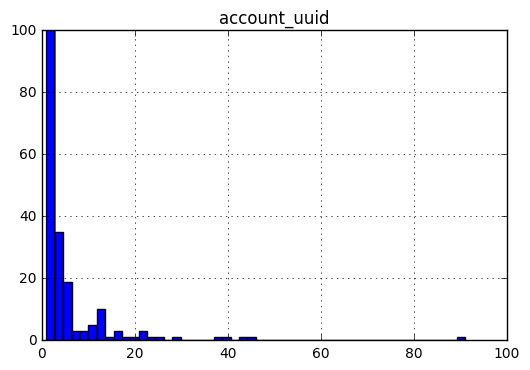

In [13]:
customer_name_groups.hist(bins=50)

In [14]:
account_groups = account_df[['account_uuid','meter_uuid']].groupby('account_uuid').count()
account_groups.head()

,meter_uuid
account_uuid,
10619946005730,2
10621170000000,3
10621170106419,1
10621170108142,1
10621170111153,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107fccf50>]], dtype=object)

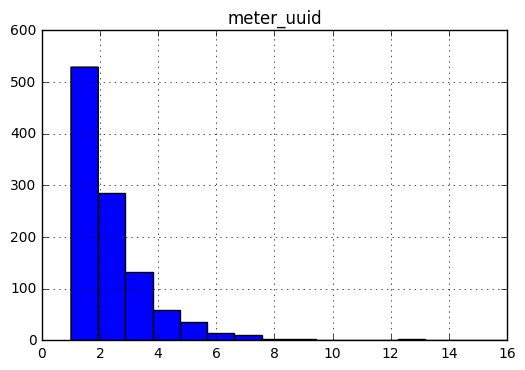

In [15]:
account_groups.hist(bins=16)